## Splitting records

Some article records have multiple authors and affiliations. For author analysis, we want to split those records.

In [199]:
import pandas as pd

sage_records_file = '../data/sage-crawl-records.json'

# load the csv data into a data frame
df_sage = pd.read_json(sage_records_file)
# show the first and last records of the dataset to demonstrate what the records look like
#df_sage

In [200]:
df_sage.journal.value_counts()

International Migration Review    5505
Name: journal, dtype: int64

In [201]:
wiley_records_file = '../data/wiley-IM-records.json'

# load the csv data into a data frame
df_wiley = pd.read_json(wiley_records_file)
# show the first and last records of the dataset to demonstrate what the records look like
#df_wiley


In [202]:
df_wiley.journal.value_counts()

International Migration    1629
Migracion                    34
Migration                    27
Name: journal, dtype: int64

In [203]:
# Make sure same journal name is used throughout data set
df_wiley.journal = 'International Migration'
#df_wiley

### Concatenating the two datasets

The two datasets have the same columns, so we can merge and look for authors that appear in both datasets. 

We remove records for articles where the author is not specified. This leave 6340 out of 7195 articles.

In [229]:
# concatenate and make a single data frame
df = pd.concat([df_wiley, df_sage], ignore_index=True)

print('Number of articles in the combined dataset:', len(df))
print('Number of articles with no specified author:', len(df[df.article_author_index_name == '']))
print('Number of articles with specified author(s):', len(df[df.article_author_index_name != '']))
print('\n\n')
df = df[df.article_author_index_name != '']
df

Number of articles in the combined dataset: 7195
Number of articles with no specified author: 855
Number of articles with specified author(s): 6340





,article_title,article_doi,article_author,article_author_index_name,article_author_affiliation,article_page_range,article_pub_date,article_pub_year,issue_section,journal,volume,issue,issue_title,issue_page_range,issue_pub_date,issue_pub_year,publisher
0,Community Services and Out-Migration,https://onlinelibrary.wiley.com/doi/10.1111/j....,Douglas S. Massey && Nathalie Williams && Will...,"Massey, Douglas S && Williams, Nathalie && Axi...",&& && &&,1-41,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley
1,Europe's Migration Agreements with Migrant-Sen...,https://onlinelibrary.wiley.com/doi/10.1111/j....,Aderanti Adepoju && Femke Van Noorloos && Anne...,"Adepoju, Aderanti && van Noorloos, Femke && Zo...",&& &&,42-75,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley
2,International Migration and Development in Asi...,https://onlinelibrary.wiley.com/doi/10.1111/j....,Maruja M.B. Asis && Nicola Piper && Parvati Ra...,"Asis, Maruja MB && Piper, Nicola && Raghuram, ...",&& &&,76-106,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley
3,Theoretical Considerations and Empirical Evide...,https://onlinelibrary.wiley.com/doi/10.1111/j....,Nicholas P. Glytsos,"Glytsos, Nicholas P",,107-130,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley
4,"Causes, Challenges and Prospects of Brain Drai...",https://onlinelibrary.wiley.com/doi/10.1111/j....,Mussie Tessema,"Tessema, Mussie",,131-157,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7178,16 Turkey: Late Entrant into Europe's Work Force,https://journals.sagepub.com/doi/pdf/10.1177/0...,Nermin Abadan-unat,"Abadan-unat, Nermin",University of Ankara,307-336,"Jan 1, 1993",1993,Article,International Migration Review,27,1_suppl,"International Migration Review - Volume 27, Nu...",NaN,"Jan 01, 1993",1993,Sage Publishing
7179,17 Yugoslavia: Emigration Out of Necessity?,https://journals.sagepub.com/doi/pdf/10.1177/0...,Silva Meznaric & Jadranka Caci-kumpes,"Meznaric, Silva & Caci-kumpes, Jadranka",Institute for Migration and Ethnic Studies Uni...,337-345,"Jan 1, 1993",1993,Article,International Migration Review,27,1_suppl,"International Migration Review - Volume 27, Nu...",NaN,"Jan 01, 1993",1993,Sage Publishing
7180,18 Japan: The Issue of Migrant Workers,https://journals.sagepub.com/doi/pdf/10.1177/0...,Masatoshi Muto,"Muto, Masatoshi","Ministry of Foreign Affairs, Tokyo",348-352,"Jan 1, 1993",1993,Article,International Migration Review,27,1_suppl,"International Migration Review - Volume 27, Nu...",NaN,"Jan 01, 1993",1993,Sage Publishing
7181,19 Post-Soviet Emigration: Today and Tomorrow,https://journals.sagepub.com/doi/pdf/10.1177/0...,Lilia Shevtsova,"Shevtsova, Lilia","USSR Academy of Sciences, Moscow",353-369,"Jan 1, 1993",1993,Article,International Migration Review,27,1_suppl,"International Migration Review - Volume 27, Nu...",NaN,"Jan 01, 1993",1993,Sage Publishing


## Clustering Author Names

We want to see which authors published in both journals, and how often. This requires a number of transformations:

1. splitting records of multi-author papers into a record per author
2. normalising author names such that variant spellings are mapped to a single version. 

The latter step is always a risky operation, because using only the surface form of a name can results in two persons with similar names being considered as a single person. Given that this dataset narrowly focuses in only authors of articles in the two journals, we assume the chance that two authors have the same surname and initials is low. 


#### Splitting multi-author records

In [230]:
# Code adapted from https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe

import numpy as np
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.fillna('').str.split(' && ')))

# calculate lengths of splits
lens = df['article_author'].fillna('').str.split(' && ').map(len)

# create new dataframe, repeating or chaining as appropriate
df_split = pd.DataFrame({
    'journal': np.repeat(df['journal'], lens),
    'issue_pub_year': np.repeat(df['issue_pub_year'], lens),
    'article_author': chainer(df['article_author']),
    'article_author_index_name': chainer(df['article_author_index_name']),
    'article_author_affiliation': chainer(df['article_author_affiliation'])
})

df_split = df_split.reset_index(drop=True)
df_split

,journal,issue_pub_year,article_author,article_author_index_name,article_author_affiliation
0,International Migration,2010,Douglas S. Massey,"Massey, Douglas S",
1,International Migration,2010,Nathalie Williams,"Williams, Nathalie",
2,International Migration,2010,William G. Axinn,"Axinn, William G",
3,International Migration,2010,Dirgha J. Ghimire,"Ghimire, Dirgha J",
4,International Migration,2010,Aderanti Adepoju,"Adepoju, Aderanti",
...,...,...,...,...,...
6769,International Migration Review,1993,Nermin Abadan-unat,"Abadan-unat, Nermin",University of Ankara
6770,International Migration Review,1993,Silva Meznaric & Jadranka Caci-kumpes,"Meznaric, Silva & Caci-kumpes, Jadranka",Institute for Migration and Ethnic Studies Uni...
6771,International Migration Review,1993,Masatoshi Muto,"Muto, Masatoshi","Ministry of Foreign Affairs, Tokyo"
6772,International Migration Review,1993,Lilia Shevtsova,"Shevtsova, Lilia","USSR Academy of Sciences, Moscow"


#### Normalising author names

There is a lot of variation in how author names are represented. Sometimes with full first and middle names, sometime with only the first name or only initials, or the first name in full but the middle names as initials.

We start from the author format where the surname is followed by the first and middle names (field `article_author_index_name`). We apply the following normalisation and mapping steps:

1. transform the `article_author_index_name` to title casing (meaning each initial character of a name part is uppercase and the rest is lowercase),
2. remove everything after the first letter that follows the surname,
3. transform all uses of `ij` to `y` as this Dutch and German names containing `ij` are sometimes spelled with `y`, e.g. `Gunther Beijer` vs. `Gunther Beyer`.


In [231]:
def acronym(string):
    if string == 'International Migration':
        return 'IM'
    else:
        return 'IMR'


def parse_surname(author_name: str):
    return author_name.split(',')[0].replace('ij', 'y').title()


def parse_surname_initial(author_name: str):
    if ',' not in author_name:
        return author_name
    surname = author_name.split(',')[0].replace('ij', 'y').title()
    initial = author_name.split(', ')[1][0]
    return f'{surname}, {initial}'


df_split['article_author_index_name'] = df_split['article_author_index_name'].str.title()
df_split['author_surname_initial'] = df_split.article_author_index_name.apply(parse_surname_initial)
df_split['issue_pub_decade'] = df_split.issue_pub_year.apply(lambda x: int(x/10)*10)

df_split.journal = df_split.journal.apply(acronym)

df_split

,journal,issue_pub_year,article_author,article_author_index_name,article_author_affiliation,author_surname_initial,issue_pub_decade
0,IM,2010,Douglas S. Massey,"Massey, Douglas S",,"Massey, D",2010
1,IM,2010,Nathalie Williams,"Williams, Nathalie",,"Williams, N",2010
2,IM,2010,William G. Axinn,"Axinn, William G",,"Axinn, W",2010
3,IM,2010,Dirgha J. Ghimire,"Ghimire, Dirgha J",,"Ghimire, D",2010
4,IM,2010,Aderanti Adepoju,"Adepoju, Aderanti",,"Adepoju, A",2010
...,...,...,...,...,...,...,...
6769,IMR,1993,Nermin Abadan-unat,"Abadan-Unat, Nermin",University of Ankara,"Abadan-Unat, N",1990
6770,IMR,1993,Silva Meznaric & Jadranka Caci-kumpes,"Meznaric, Silva & Caci-Kumpes, Jadranka",Institute for Migration and Ethnic Studies Uni...,"Meznaric, S",1990
6771,IMR,1993,Masatoshi Muto,"Muto, Masatoshi","Ministry of Foreign Affairs, Tokyo","Muto, M",1990
6772,IMR,1993,Lilia Shevtsova,"Shevtsova, Lilia","USSR Academy of Sciences, Moscow","Shevtsova, L",1990


### Looking at author overlap between journal

There following 212 authors who have published in both journals:

In [274]:
g = df_split[df_split.author_surname_initial.isna() == False].groupby(['author_surname_initial', 'journal']).journal.count()
df_overlap = g.unstack('journal').fillna(0.0)
df_overlap[(df_overlap.IM > 0) & (df_overlap.IMR > 0)]


journal,IM,IMR
author_surname_initial,,
"Adepoju, A",11.0,1.0
"Afolayan, A",1.0,1.0
"Agadjanian, V",2.0,2.0
"Al-Qudsi, S",1.0,1.0
"Allen, R",1.0,1.0
...,...,...
"Young, C",1.0,1.0
"Zhou, M",1.0,5.0
"Zlotnik, H",2.0,7.0


There are 54 authors who published at least two articles in each journal. Here we see Gunther Beijer and and Jerzy Zubrzicki, who are also directly involved in the REMP publications:

In [275]:
g = df_split[df_split.author_surname_initial.isna() == False].groupby(['author_surname_initial', 'journal']).journal.count()
df_overlap = g.unstack('journal').fillna(0.0)
print('number of authors with at least two articles in both journals:', 
      len(df_overlap[(df_overlap.IM > 1) & (df_overlap.IMR > 1)]))

df_overlap[(df_overlap.IM > 1) & (df_overlap.IMR > 1)]

number of authors with at least two articles in both journals: 54


journal,IM,IMR
author_surname_initial,,
"Agadjanian, V",2.0,2.0
"Appleyard, R",25.0,3.0
"Basok, T",2.0,5.0
"Beenstock, M",3.0,2.0
"Bernard, W",6.0,7.0
"Beyer, G",16.0,3.0
"Brandon, P",2.0,2.0
"Burnley, I",2.0,3.0
"Böhning, W",4.0,7.0


In [236]:
print('Number of authors in both journals combined:', len(df_overlap))
print('Number of authors in International Migration:', len(df_overlap[df_overlap.IM > 0]))
print('Number of authors in International Migration Review:', len(df_overlap[df_overlap.IMR > 0]))


Number of authors in both journals combined: 3682
Number of authors in International Migration: 1201
Number of authors in International Migration Review: 2693


The 212 authors with articles in both journals represent 18% of all IM authors ($212 / 1201 = 0.18$) and 8% ($212 / 2693 = 0.08$) of all IMR authors. 

In [241]:
print(round(212/1201, 2))
print(round(212/2693, 2))

0.18
0.08


In [245]:
print('Number of persons who published multiple articles in IM:', len(df_overlap[df_overlap.IM > 1]))

print('Number of multi-IM authors who also published in IMR:', len(df_overlap[(df_overlap.IM > 1) & (df_overlap.IMR > 0)]))

Number of persons who published multiple articles in IM: 227
Number of multi-IM authors who also published in IMR: 91


In [246]:
print('Number of persons who published multiple articles in IMR:', len(df_overlap[df_overlap.IMR > 1]))

print('Number of multi-IMR authors who also published in IM:', len(df_overlap[(df_overlap.IMR > 1) & (df_overlap.IM > 0)]))

Number of persons who published multiple articles in IMR: 769
Number of multi-IMR authors who also published in IM: 109


In [252]:
print('IM:', len(df_overlap[df_overlap.IM > 1]) / len(df_overlap[df_overlap.IM > 0]))
print('IMR:', len(df_overlap[df_overlap.IMR > 1]) / len(df_overlap[df_overlap.IMR > 0]))

print('IM:', len(df_overlap[df_overlap.IM > 4]) / len(df_overlap[df_overlap.IM > 0]))
print('IMR:', len(df_overlap[df_overlap.IMR > 4]) / len(df_overlap[df_overlap.IMR > 0]))



IM: 0.18900915903413823
IMR: 0.28555514296323803
IM: 0.019150707743547043
IMR: 0.05124396583735611


In [262]:
print(df_overlap[df_overlap.IMR > 1].shape)
df_overlap[df_overlap.IMR > 1].IM.value_counts()

(769, 2)


0.0     660
1.0      55
2.0      21
4.0      11
3.0       9
5.0       3
8.0       2
11.0      2
6.0       2
7.0       1
14.0      1
16.0      1
25.0      1
Name: IM, dtype: int64

In [264]:
print(df_overlap[df_overlap.IM > 1].shape)
df_overlap[df_overlap.IM > 1].IMR.value_counts()

(227, 2)


0.0     136
1.0      37
2.0      21
3.0      10
7.0       6
4.0       4
5.0       4
8.0       2
9.0       2
6.0       1
13.0      1
27.0      1
40.0      1
14.0      1
Name: IMR, dtype: int64

In [263]:
305/371
660/769

0.8582574772431729

<AxesSubplot:xlabel='IM', ylabel='IMR'>

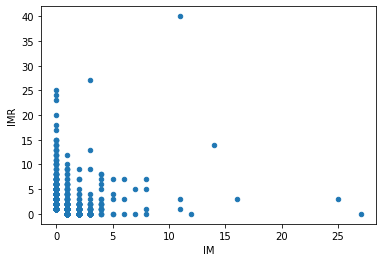

In [279]:
df_overlap.plot(kind='scatter', x='IM', y='IMR')

In [278]:
g = df_split[(df_split.author_surname_initial.isna() == False) & (df_split.author_surname_initial != '')].groupby(['author_surname_initial', 'journal']).journal.count()
df_overlap = g.unstack('journal').fillna(0.0)
df_overlap

journal,IM,IMR
author_surname_initial,,
"Abadan-Unat, N",0.0,6.0
"Abaka, E",0.0,1.0
"Abalos, D",0.0,1.0
"Abandan-Unat, N",0.0,1.0
"Abascal, M",0.0,1.0
...,...,...
"Ávila, F",1.0,0.0
"Åkesson, L",1.0,0.0
"Åslund, O",0.0,1.0


In [277]:
df_split[df_split.author_surname_initial.isna() == False]

,journal,issue_pub_year,article_author,article_author_index_name,article_author_affiliation,author_surname_initial,issue_pub_decade
0,IM,2010,Douglas S. Massey,"Massey, Douglas S",,"Massey, D",2010
1,IM,2010,Nathalie Williams,"Williams, Nathalie",,"Williams, N",2010
2,IM,2010,William G. Axinn,"Axinn, William G",,"Axinn, W",2010
3,IM,2010,Dirgha J. Ghimire,"Ghimire, Dirgha J",,"Ghimire, D",2010
4,IM,2010,Aderanti Adepoju,"Adepoju, Aderanti",,"Adepoju, A",2010
...,...,...,...,...,...,...,...
6769,IMR,1993,Nermin Abadan-unat,"Abadan-Unat, Nermin",University of Ankara,"Abadan-Unat, N",1990
6770,IMR,1993,Silva Meznaric & Jadranka Caci-kumpes,"Meznaric, Silva & Caci-Kumpes, Jadranka",Institute for Migration and Ethnic Studies Uni...,"Meznaric, S",1990
6771,IMR,1993,Masatoshi Muto,"Muto, Masatoshi","Ministry of Foreign Affairs, Tokyo","Muto, M",1990
6772,IMR,1993,Lilia Shevtsova,"Shevtsova, Lilia","USSR Academy of Sciences, Moscow","Shevtsova, L",1990
